In [245]:
# Import packages
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import os
import dill, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack
from astropy.coordinates import SkyCoord

from PIL import Image

sys.path.append('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/script/')

In [247]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

## Size distribution 
1. Subtract background contribution
2. Correct for completeness

In [248]:
from paper_figure import plot_size_distribution
kz.set_matplotlib(style='JL', usetex=True, dpi=100, fontsize=16)

Total angular area [deg2]: 32.70887732960614


sample: 100%|███████████| 4000/4000 [00:04<00:00, 979.53it/s, 11 steps of size 2.05e-01. acc. prob=0.96]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -1.58      0.30     -1.55     -2.02     -1.07    569.42      1.00
         b      1.85      0.11      1.85      1.67      2.03    619.30      1.00

Number of divergences: 0
Total angular area [deg2]: 32.36912377009267


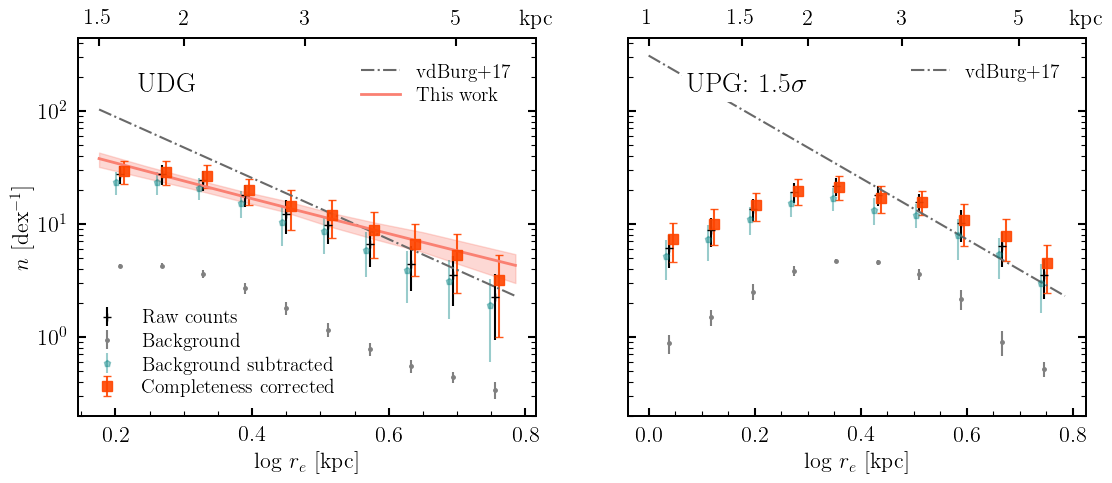

In [250]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax1 = plot_size_distribution(udg_cat, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UDG', ax=ax1, 
                                  fit_line=True, refit=True, verbose=True)
xlim = ax1.get_xlim()
plt.text(0.13 * (xlim[1] - xlim[0]) + xlim[0], 150, 'UDG', fontsize=20,
         bbox=dict(facecolor='w', alpha=1, edgecolor='none'))


### UPG ###
name = 'upg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = 1.5

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

_, ind = np.unique(udg_cat['host_name'].data, return_index=True)
total_area = (np.pi * (udg_cat['host_r_vir_ang'].data[ind]**2)).sum() # deg^2 #  - (3/60)**2
print('Total angular area [deg2]:', total_area)

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax2 = plot_size_distribution(udg_cat, fake_udg_cat, total_area, 24, 
                                  fake_udg_repeats=10*20, name='UPG_1.5sigma', ax=ax2, fit_line=False,
                                  range_0=np.array([np.log10(1), np.log10(6.1)]), 
                                  dots_legend=False)
ax2.set_ylabel('')
xlim = ax2.get_xlim()
plt.text(0.13 * (xlim[1] - xlim[0]) + xlim[0], 150, r'UPG: 1.5$\sigma$', fontsize=20,
         bbox=dict(facecolor='w', alpha=1, edgecolor='none'))

import matplotlib
y_minor = matplotlib.ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
ax2.yaxis.set_minor_locator(y_minor)
ax2.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())

# plt.tight_layout()
# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/size_distribution.pdf', 
#             bbox_inches='tight', dpi=50)

---

## Spatial distribution

In [251]:
from colossus.cosmology import cosmology
from colossus.halo import profile_nfw, profile_einasto
from sample_cuts import moving_binned_statistic
from paper_figure import plot_radial_number_profile

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 13 steps. Best-fit parameters:
Parameter       rhos = 7.13e+00 [4.18e+00 .. 1.22e+01]
Parameter         rs = 2.99e-01 [2.32e-01 .. 3.85e-01]
chi2 / Ndof = 9.5 / 11 = 0.86
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 3 / 3 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 22 steps. Best-fit parameters:
Parameter       rhos = 1.73e+00 [8.62e-01 .. 3.46e+00]
Parameter         rs = 3.22e-01 [2.33e-01 .. 4.47e-01]
Parameter      alpha = 6.29e-01 [3.66e-01 .. 1.08e+00]
chi2 / Ndof = 8.7 / 10 = 0.87
-------------------------------------------------------------------------------------
NFW conc = 3.

(0.05, 1.05)

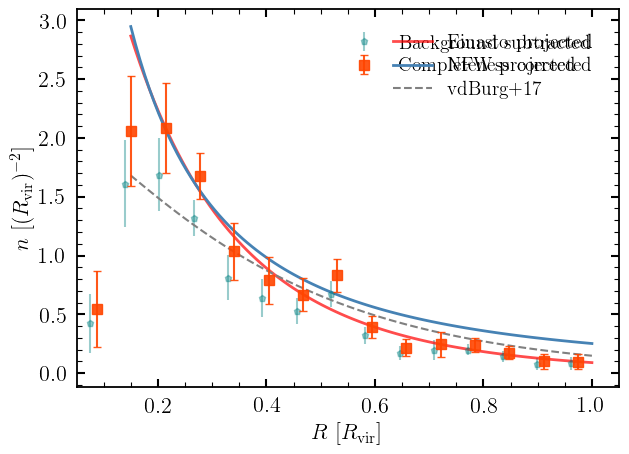

In [252]:
fig, ax = plt.subplots(figsize=(7, 5), sharey=True)

name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=15,
                                     fake_udg_repeats=10*20, name='UDG', ax=ax, r_min=0.15,
                                     refit=False, verbose=True)
plt.xlim(0.05, 1.05)

# plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/radial_distribution.pdf',
#             bbox_inches='tight', dpi=50)

---

-------------------------------------------------------------------------------------
Profile fit: Varying 2 / 2 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 13 steps. Best-fit parameters:
Parameter       rhos = 7.35e+00 [4.32e+00 .. 1.25e+01]
Parameter         rs = 3.01e-01 [2.34e-01 .. 3.88e-01]
chi2 / Ndof = 10.5 / 11 = 0.95
-------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------
Profile fit: Varying 3 / 3 parameters.
Could not find analytical derivative function for quantity Sigma.
Found solution in 22 steps. Best-fit parameters:
Parameter       rhos = 1.86e+00 [8.83e-01 .. 3.91e+00]
Parameter         rs = 3.18e-01 [2.24e-01 .. 4.51e-01]
Parameter      alpha = 6.04e-01 [3.43e-01 .. 1.07e+00]
chi2 / Ndof = 8.9 / 10 = 0.89
-------------------------------------------------------------------------------------
NFW conc = 3

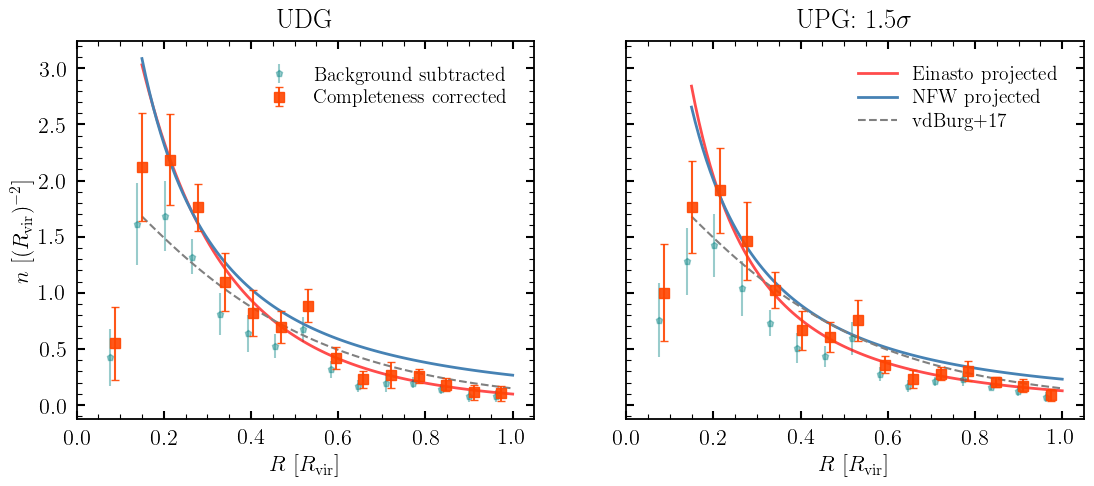

In [256]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

### UDG ###
name = 'udg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = None

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_w_missed.fits')
flag = (udg_cat['rhalf_phys'] + udg_cat['rhalf_phys_err'] >= 1.5
       ) & (udg_cat['SB_eff_avg'][:, 0] + udg_cat['SB_eff_avg_err'][:, 0] >= 25)
udg_cat = udg_cat[flag]
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]

fig, ax1 = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=15,
                                     fake_udg_repeats=10*20, name='UDG', ax=ax1, r_min=0.2,
                                     refit=False, verbose=True, dots_legend=True, lines_legend=False)

### UPG ###
name = 'upg'
GALARY = '/tigress/jiaxuanl/public_html/galary/'
thresh = 1.5

udg_cat = Table.read(
    f'{GALARY}/catalogs/nsa_z001_004/{name}_z001_004_spergel_after_viz_{thresh}sigma.fits')
udg_cat = udg_cat[udg_cat['completeness'] > 0.1]

fake_udg_cat = Table.read(f'./Catalog/random_field/fake_{name}_cat_{thresh}sigma_220726.fits')
fake_udg_cat = fake_udg_cat[fake_udg_cat['completeness'] > 0.1]


fig, ax2 = plot_radial_number_profile(udg_cat, fake_udg_cat, 24, n_bins=15,
                                     fake_udg_repeats=10*20, name='UPG_1.5sigma', ax=ax2, r_min=0.2,
                                     refit=False, verbose=True, dots_legend=False, lines_legend=True)
ax2.set_ylabel('')
ax1.set_title('UDG')
ax2.set_title('UPG: $1.5\sigma$')

# plt.tight_layout()
plt.savefig('/tigress/jiaxuanl/public_html/figure/udg_paper/radial_distribution.pdf',
            bbox_inches='tight', dpi=50)

---